In [491]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [492]:
df_new = pd.read_csv('df_new.csv', index_col=0)
df_new.head()

,word,length,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,polysemy,web_corpus_freq
1,abbey,5,1.767767,5.781,4.667,5.906,5.344,3.324,5.177,5.121,3.303,0,22.010473
2,abbreviate,10,1.809143,5.250,5.235,3.286,3.177,5.121,5.543,2.667,3.971,0,17.096149
3,abdicate,8,2.047926,3.767,4.419,3.367,2.516,3.971,6.233,4.679,5.167,0,16.921411
4,abdication,10,1.961122,3.880,4.800,3.292,2.571,3.097,6.407,5.083,4.571,0,16.967395
5,abdomen,7,2.171175,5.486,5.441,6.606,6.235,4.636,5.457,3.529,4.600,0,20.507543


In [493]:
df_new.dtypes

word                object
length               int64
arousal            float64
valence            float64
dominance          float64
concreteness       float64
imageability       float64
familiarity        float64
aoa                float64
semsize            float64
gender             float64
polysemy             int64
web_corpus_freq    float64
dtype: object

In [494]:
cols = [col for col in df_new.columns if col != 'word']     # elimino word
cols = [col for col in cols if col != 'polysemy']           # elimino polysemy
#cols = [col for col in cols if col != 'length']             # elimino length
cols = [col for col in cols if col != 'concreteness']       # elimino concreteness
cols = [col for col in cols if col != 'dominance']          # elimino dominance
cols = [col for col in cols if col != 'familiarity']        # elimino familiarity


#cols = [col for col in df_new.columns if col != 'word']    #ripristino

In [495]:
###### Lecture Pipeline ######
# you can/have to modify the order for your project,
# e.g. hyperparameter tuning before evaluating a decision tree

# Hold-out
from sklearn.model_selection import train_test_split

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Optional: KNN
from sklearn.neighbors import KNeighborsClassifier

##### Decision Tree Visualization ###


from sklearn import tree # export_graphviz() method

from IPython.display import Image # viz stuff

import pydotplus # viz stuff                              ########### PROBLEM !!!!!!!!!!!!!!!!!


####################################

######## Evaluation #######                Per valurare i risultati del Decision tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Optional: baseline comparison
from sklearn.dummy import DummyClassifier
###########################

# hyperparameter tuning ################## Per cercare i parametri più adatti per il Decision Tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# cross-validation ##################### Alternativa all hold out method
from sklearn.model_selection import cross_val_score

In [496]:
# if you have problem with the Decision Tree Visualization

#import os
#os.environ['PATH'] += os.pathsep + 'C:/Users/Username/Anaconda3/Library/bin/graphviz'

# Train -Test


In [497]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

undersample = RandomUnderSampler(sampling_strategy='majority') 
oversample = RandomOverSampler(sampling_strategy=0.5)          ########## usare nel Train

In [498]:
# Hold-out

X_or = df_new[cols].values
y_or = df_new['polysemy']

X_train_or, X_test, y_train_or, y_test = train_test_split(X_or, y_or, test_size = 0.1, stratify= y_or, 
                                        random_state = 100 ) #because it is a random split

X_over, y_over = oversample.fit_resample(X_train_or, y_train_or)

X, y = undersample.fit_resample(X_over, y_over)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, 
                                        random_state= 100, stratify = y) #viene creato un validation set


print("df_new.shape :     ",df_new.shape)
print("X_train_or.shape : ",X_train_or.shape)
print("X_test.shape :     ",X_test.shape)
print("X_train.shape :    ",X_train.shape)
print("X_val.shape :      ",X_val.shape)
print('X iniziale: -------', X_train_or.shape, '\n y iniziale:', Counter(y_train_or))
print('X over:------------', X_over.shape, '\n y over:    ', Counter(y_over))
print('X:-----------------', X.shape, '\n y: ', Counter(y))


df_new.shape :      (4357, 13)
X_train_or.shape :  (3921, 8)
X_test.shape :      (436, 8)
X_train.shape :     (3227, 8)
X_val.shape :       (359, 8)
X iniziale: ------- (3921, 8) 
 y iniziale: Counter({0: 3587, 1: 334})
X over:------------ (5380, 8) 
 y over:     Counter({0: 3587, 1: 1793})
X:----------------- (3586, 8) 
 y:  Counter({0: 1793, 1: 1793})


In [499]:
len(df_new), X_train.shape[0], X_test.shape[0]

(4357, 3227, 436)

In [500]:
df_new.shape,df_new[cols].shape, X_train.shape, X_test.shape

((4357, 13), (4357, 8), (3227, 8), (436, 8))

# Tuning the hyper-parameters

In [501]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [502]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),    # fa le prove e vede quali valori sono i migliori
             'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
             'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100]
             }

grid_search = GridSearchCV(clf, param_grid=param_list, scoring='f1')
grid_search.fit(X_train_or, y_train_or)
res = grid_search.cv_results_


In [503]:
report(res, n_top=10)

Model with rank: 1
Mean validation score: 0.207 (std: 0.037)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.202 (std: 0.049)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

Model with rank: 3
Mean validation score: 0.200 (std: 0.049)
Parameters: {'max_depth': 19, 'min_samples_leaf': 5, 'min_samples_split': 5}

Model with rank: 4
Mean validation score: 0.200 (std: 0.053)
Parameters: {'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 10}

Model with rank: 5
Mean validation score: 0.198 (std: 0.037)
Parameters: {'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 5}

Model with rank: 6
Mean validation score: 0.198 (std: 0.037)
Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 7
Mean validation score: 0.197 (std: 0.046)
Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 8


In [504]:
grid_search.best_estimator_ # !!!!!!!!!!!!!!!!!!!!!!!!!!!

DecisionTreeClassifier()

In [505]:
random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=50, cv=4)
random_search.fit(X_train_or, y_train_or)
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.915 (std: 0.000)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 100, 'max_depth': 9}

Model with rank: 1
Mean validation score: 0.915 (std: 0.000)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 3}

Model with rank: 1
Mean validation score: 0.915 (std: 0.000)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 3}

Model with rank: 1
Mean validation score: 0.915 (std: 0.000)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 20, 'max_depth': 2}

Model with rank: 1
Mean validation score: 0.915 (std: 0.000)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 100, 'max_depth': 17}

Model with rank: 1
Mean validation score: 0.915 (std: 0.000)
Parameters: {'min_samples_split': 50, 'min_samples_leaf': 50, 'max_depth': 4}

Model with rank: 1
Mean validation score: 0.915 (std: 0.000)
Parameters: {'min_samples_split': 100, 'min_samples_leaf': 10, 'max_depth': 2}

Model with rank

# Decision tree - build mode

In [506]:
clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None , min_samples_split=5, min_samples_leaf=20)

# usare GINI o ENTROPY per decidere il metodo di split ( ce ne sono altre ma sklearn ha solo queste)
# max_depth : a che livello si deve fermare l'albero
#min_samples_split : minimo numero di record in un nodo perché sia conveniente splittare
#min_samples_leaf  : minimo numero di record accettabile nei figli per essere conveniente spittare

clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=20, min_samples_split=5)

In [507]:
clf.feature_importances_

array([0.31955523, 0.13918337, 0.04090122, 0.03738821, 0.05425085,
       0.11660364, 0.0360529 , 0.25606458])

In [508]:
imp_dict = {attr: clf_dt.feature_importances_[i] for i, attr in enumerate(cols)}
imp_dict

{'length': 0.30338627730398376,
 'arousal': 0.057015843656663054,
 'valence': 0.03743222276907714,
 'imageability': 0.09851945657441925,
 'aoa': 0.1257081655229075,
 'semsize': 0.15110267858336796,
 'gender': 0.05168824327386788,
 'web_corpus_freq': 0.17514711231571353}

In [509]:
# metto in ordine di importanza ___________ metodo per mettere in ordine un dictionary in python
{k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)} 

{'length': 0.30338627730398376,
 'web_corpus_freq': 0.17514711231571353,
 'semsize': 0.15110267858336796,
 'aoa': 0.1257081655229075,
 'imageability': 0.09851945657441925,
 'arousal': 0.057015843656663054,
 'gender': 0.05168824327386788,
 'valence': 0.03743222276907714}

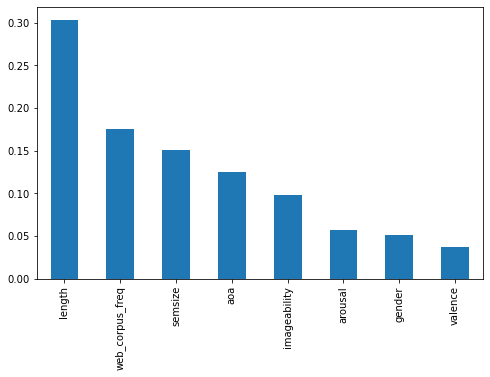

In [510]:
pd.Series(clf_dt.feature_importances_,  
         index = cols).sort_values(ascending = False).plot(kind = 'bar', figsize = (8,5));
#plt.xticks(rotation=0)

In [511]:
clf_dt.classes_ # polysemy 0 e 1

array([0, 1], dtype=int64)

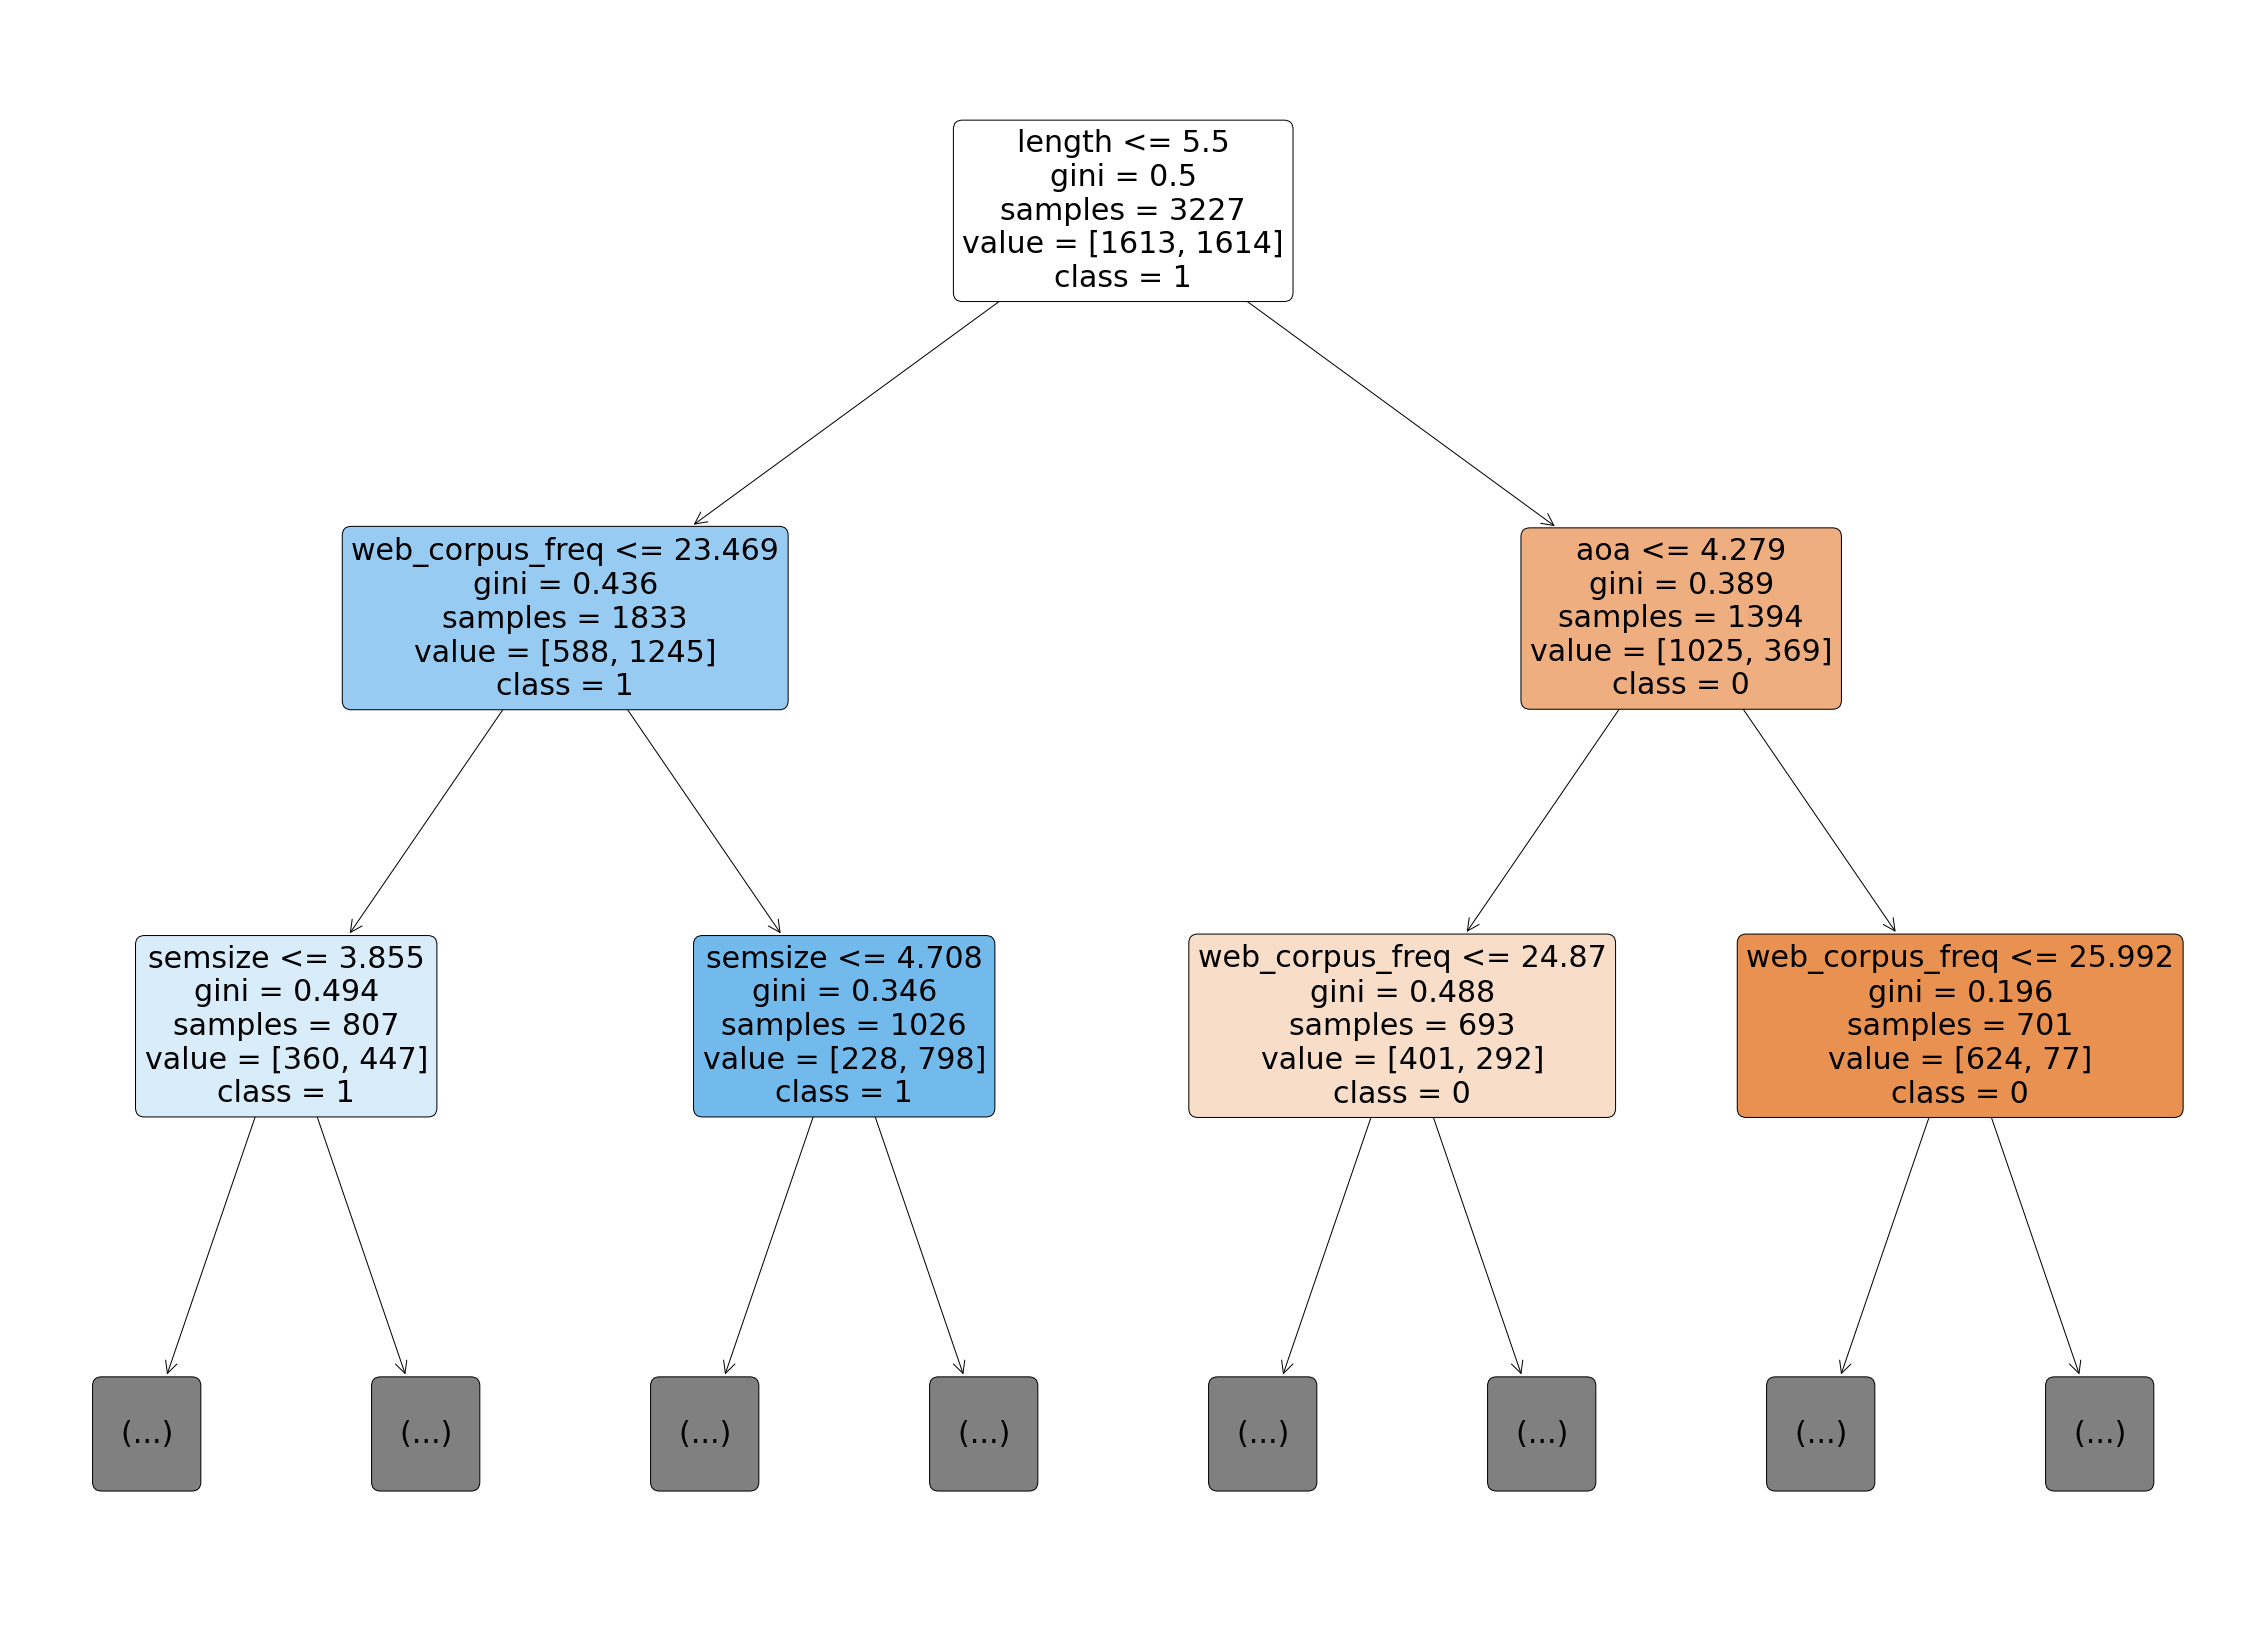

In [512]:
                                # parametri per personalizzare la visualizzazione
    
fig, ax = plt.subplots(figsize=(40, 30))    

tree.plot_tree                 (clf_dt,               # this is for the following plot
                                feature_names= cols, 
                                class_names=[str(v) for v in clf_dt.classes_], 
                                filled=True, rounded=True,  
                                impurity= True ,
                                fontsize = 30,  # change this to change fontsize in the node
                                max_depth=2)    # change this value to change the level of tree
    
#dot_data = tree.export_graphviz (clf_dt,       # this is for the image
#                                out_file=None,
#                                feature_names=cols,
#                                class_names=[str(v) for v in clf_dt.classes_],
#                                filled=True, rounded=True,
#                                special_characters=True,
#                                max_depth=2) # fino a quale nodo stampa------ Se metti None stampa tutto
#
#graph = pydotplus.graph_from_dot_data(dot_data)
plt.show()

#Image(graph.create_png())

### Accuracy 

In [513]:
y_pred = clf_dt.predict(X_train)
y_pred_val = clf_dt.predict(X_val)
y_pred[:5]

array([1, 1, 0, 0, 1], dtype=int64)

In [514]:
y_train.values[:5]

array([1, 1, 0, 0, 0], dtype=int64)

##### TRAINING SET 

In [515]:
print('Accuracy', accuracy_score(y_train, y_pred))
print('F1-score', f1_score(y_train, y_pred, average=None))
print('F1-score', f1_score(y_train, y_pred))

Accuracy 0.8466067555004648
F1-score [0.84037407 0.85237101]
F1-score 0.8523710110348941


In [516]:
print( classification_report(y_train, y_pred) )

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1613
           1       0.82      0.89      0.85      1614

    accuracy                           0.85      3227
   macro avg       0.85      0.85      0.85      3227
weighted avg       0.85      0.85      0.85      3227



In [517]:
confusion_matrix(y_train, y_pred, labels=[1,0])

array([[1429,  185],
       [ 310, 1303]], dtype=int64)

##### VALIDATION SET 

In [518]:
print('Accuracy %s' % accuracy_score(y_val, y_pred_val))
print('F1-score %s' % f1_score(y_val, y_pred_val, average=None))
print(classification_report(y_val, y_pred_val))
confusion_matrix(y_val, y_pred_val, labels=[1,0])

Accuracy 0.7855153203342619
F1-score [0.7890411  0.78186969]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       180
           1       0.79      0.77      0.78       179

    accuracy                           0.79       359
   macro avg       0.79      0.79      0.79       359
weighted avg       0.79      0.79      0.79       359



array([[138,  41],
       [ 36, 144]], dtype=int64)

### Confusion Matrix

In [519]:
# NOT SUGGESTED FOR THE PROJECT
# TN, FN, FN, TP
#cf[0][0], cf[0][1], cf[1][0], cf[1][1]

cf = confusion_matrix(y_train, y_pred)
cf

array([[1303,  310],
       [ 185, 1429]], dtype=int64)

In [520]:
# SUGGESTED FOR THE PROJECT
# TP, FN, FP, TN
#cf[0][0], cf[0][1], cf[1][0], cf[1][1]

cf = confusion_matrix(y_train, y_pred, labels=[1,0])
cf

array([[1429,  185],
       [ 310, 1303]], dtype=int64)

In [521]:
# to normalize
cf = confusion_matrix(y_train, y_pred, labels=[1,0], normalize='all')
cf

array([[0.44282615, 0.05732879],
       [0.09606446, 0.4037806 ]])

In [522]:
print('Accuracy %s' % accuracy_score(y_val, y_pred_val))
print('F1-score %s' % f1_score(y_val, y_pred_val, average=None))
print(classification_report(y_val, y_pred_val))
confusion_matrix(y_val, y_pred_val,labels=[1,0])

Accuracy 0.7855153203342619
F1-score [0.7890411  0.78186969]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       180
           1       0.79      0.77      0.78       179

    accuracy                           0.79       359
   macro avg       0.79      0.79      0.79       359
weighted avg       0.79      0.79      0.79       359



array([[138,  41],
       [ 36, 144]], dtype=int64)

Confusion matrix, without normalization
[[1429  185]
 [ 310 1303]]
Normalized confusion matrix ('all')
[[0.44282615 0.05732879]
 [0.09606446 0.4037806 ]]
Normalized confusion matrix ('true')
[[0.88537794 0.11462206]
 [0.19218847 0.80781153]]


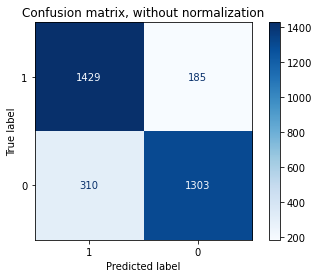

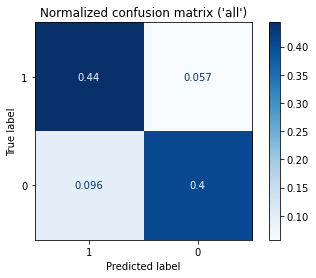

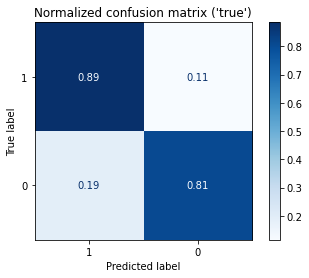

In [523]:
#CONFUSION MATRIX TRAINING SET
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix ('all')", 'all'),
                  ("Normalized confusion matrix ('true')", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_dt, X_train, y_train,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,labels=[1,0])
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix, without normalization
[[138  41]
 [ 36 144]]
Normalized confusion matrix ('all')
[[0.38440111 0.11420613]
 [0.10027855 0.40111421]]
Normalized confusion matrix ('true')
[[0.77094972 0.22905028]
 [0.2        0.8       ]]


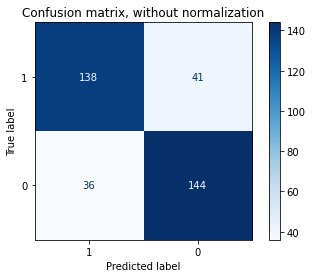

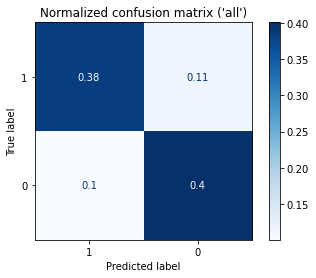

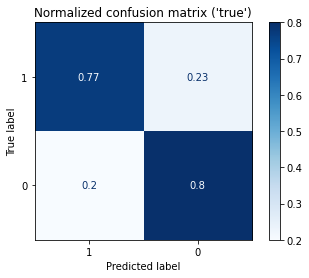

In [524]:
#CONFUSION MATRIX VALIDATION SET
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix ('all')", 'all'),
                  ("Normalized confusion matrix ('true')", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_dt, X_val, y_val,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,labels=[1,0])
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### ROC curves 

In [627]:
#Sul validation set
#from scikitplot.metrics import plot_roc # there isn't version

y_score = clf_dt.predict_proba(X_test)
y_score[:5]

array([[0.81818182, 0.18181818],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.46153846, 0.53846154]])

In [628]:
y_score[:,1][:6]

array([0.18181818, 0.        , 0.        , 0.        , 0.53846154,
       0.28571429])

In [629]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
bina_y_val = lb.fit(y_val)
bina_y_pred = lb.fit(y_pred_val)
print("Polysemy" ,lb.classes_.tolist())

bina_y_val = lb.transform(y_val)
bina_y_pred = lb.transform(y_pred_val)

fpr, tpr, th = roc_curve(bina_y_val, bina_y_pred,pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(bina_y_val, bina_y_pred, average=None)
roc_auc
# plot_roc(y_val, y_score) #from scikitplot.metrics import plot_roc # there isn't version

Polysemy [0, 1]
0.7854748603351955


0.7854748603351955

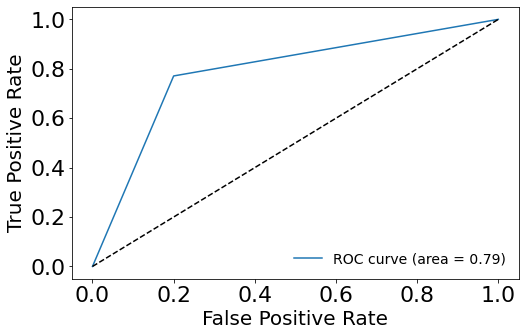

In [630]:
plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# la linea tratteggiata va da threshold=0 a threshold=1

0.7687123213439003


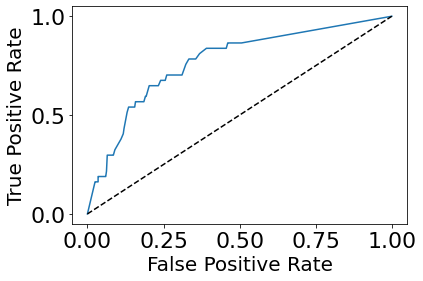

In [632]:
fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)
#plt.figure(figsize=(8,5))

plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

# Bonus

In [530]:
### KDEPLOTS just for understanding how a threshold work:
### green line to the right of the threshold are FPs
### red line to the left of the threshold are FNs
##
##import seaborn as sns
##sns.kdeplot(y_score[:,1][y_train == 1], alpha=0.5, color='red', label='TP')
##sns.kdeplot(y_score[:,1][y_train == 0], alpha=0.5, color='green', label='TN')
##
### example
##threshold = 0.75
##plt.axvline(threshold, c='black', ls='dashed')
##
##plt.legend()

[[0.50015494 0.        ]
 [0.49984506 0.        ]]


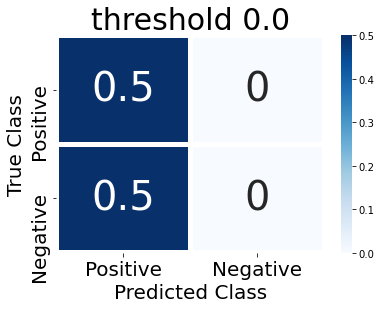

[[0.50015494 0.        ]
 [0.24883793 0.25100713]]


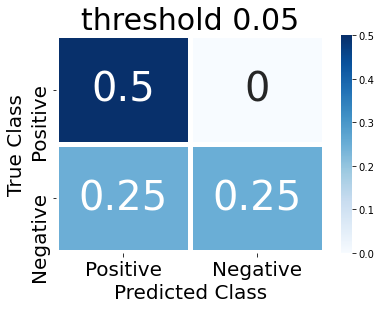

[[4.99845057e-01 3.09885342e-04]
 [2.42950108e-01 2.56894949e-01]]


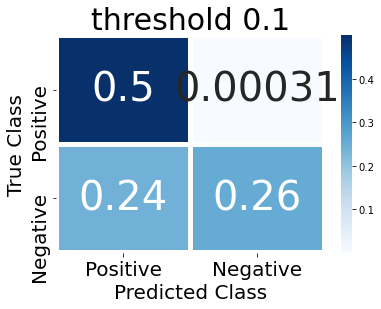

[[0.49488689 0.00526805]
 [0.20700341 0.29284165]]


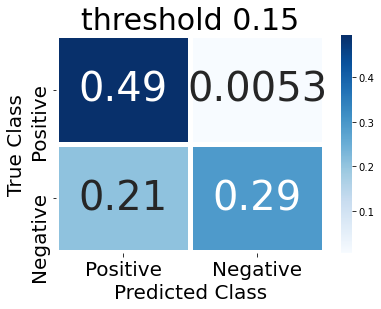

[[0.49116827 0.00898667]
 [0.18933994 0.31050511]]


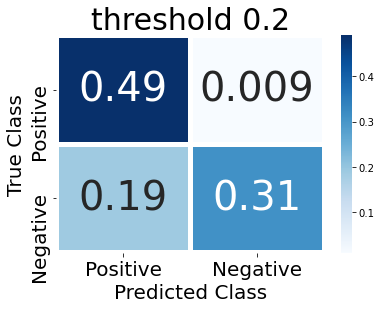

[[0.48775953 0.01239541]
 [0.1775643  0.32228076]]


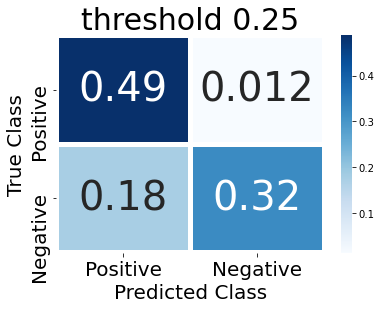

[[0.4778432  0.02231174]
 [0.15339324 0.34645181]]


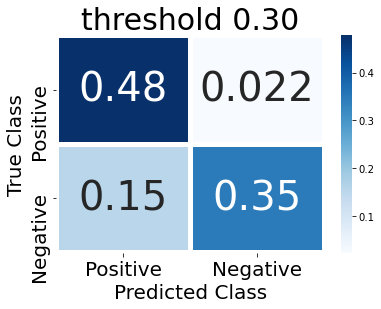

[[0.47133561 0.02881934]
 [0.14068795 0.35915711]]


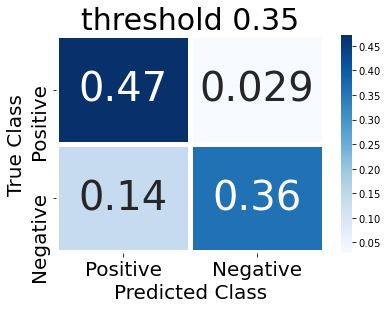

[[0.4524326  0.04772234]
 [0.10814998 0.39169507]]


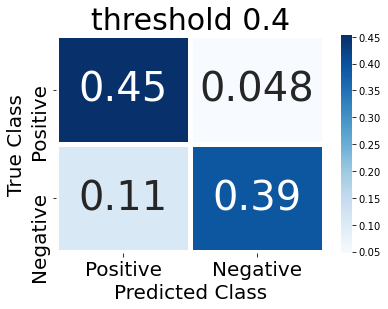

[[0.44871398 0.05144097]
 [0.10319182 0.39665324]]


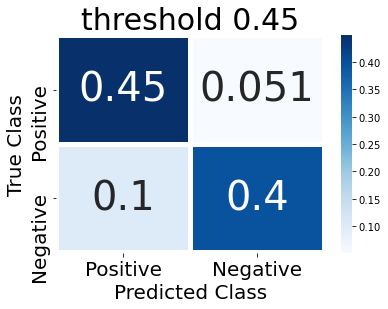

[[0.44282615 0.05732879]
 [0.09606446 0.4037806 ]]


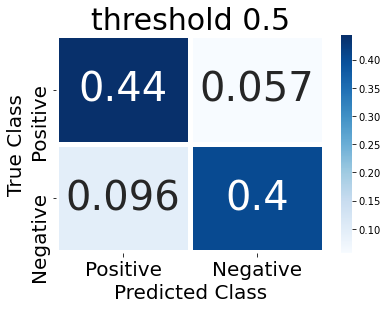

[[0.42733189 0.07282306]
 [0.0824295  0.41741556]]


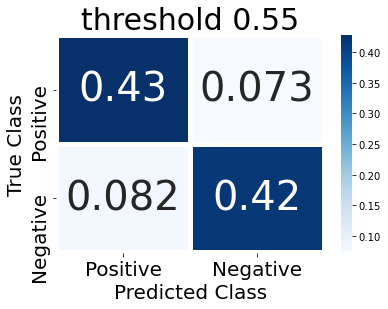

[[0.40502014 0.0951348 ]
 [0.06600558 0.43383948]]


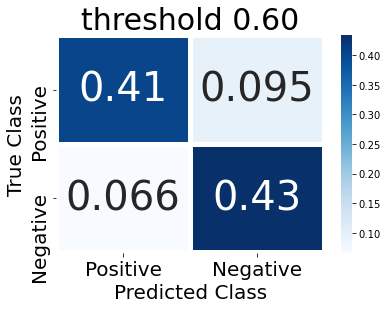

[[0.38115897 0.11899597]
 [0.05175085 0.44809421]]


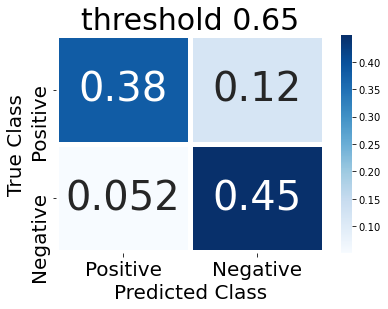

[[0.34862101 0.15153393]
 [0.0359467  0.46389836]]


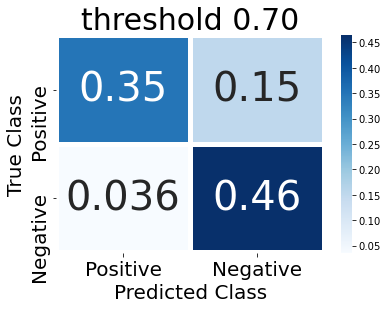

[[0.33467617 0.16547877]
 [0.03067865 0.46916641]]


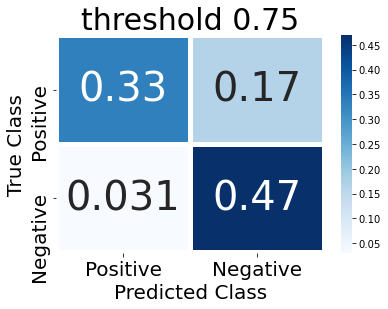

[[0.28416486 0.21599008]
 [0.0148745  0.48497056]]


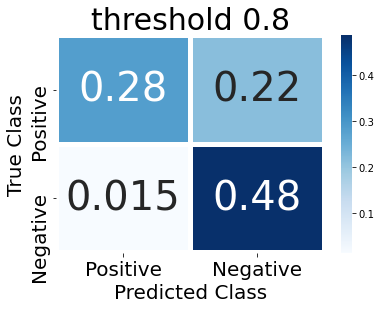

[[0.2516269  0.24852804]
 [0.00774713 0.49209792]]


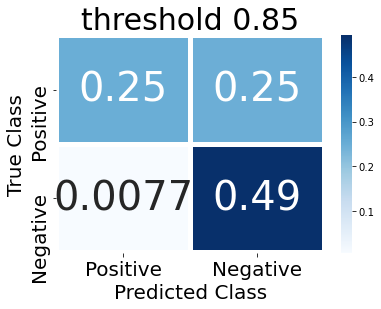

[[0.23768206 0.26247289]
 [0.00557794 0.49426712]]


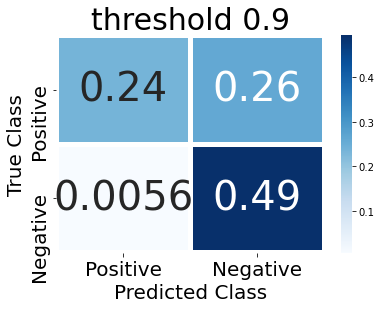

[[0.18097304 0.3191819 ]
 [0.00123954 0.49860552]]


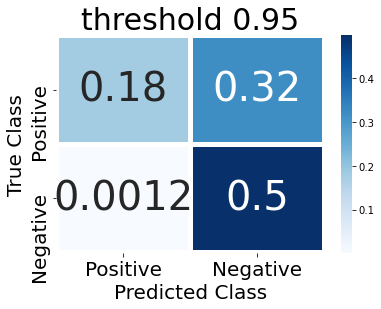

[[0.         0.50015494]
 [0.         0.49984506]]


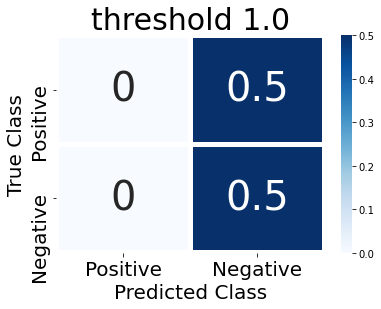

In [531]:
import seaborn as sns
for i, th in enumerate(np.arange(0,1.05,0.05)):
    if th==1:
        y_pred = [1 if v > th else 0 for v in clf_dt.predict_proba(X_train)[:,1]]
    else:
        y_pred = [1 if v >= th else 0 for v in clf_dt.predict_proba(X_train)[:,1]]
    cf = confusion_matrix(y_train, y_pred, labels=[1,0], normalize='all')
    print(cf)
    
    fig, ax = plt.subplots(figsize=(6,4)) 
    sns.heatmap(cf, annot=True, annot_kws={"size": 40}, linewidths=4, cmap="Blues")
    
    ax.set_xticklabels(['Positive','Negative'], fontsize=20)
    ax.set_xlabel('Predicted Class', fontsize=20)
    ax.set_yticklabels(['Positive','Negative'], fontsize=20)
    ax.set_ylabel('True Class', fontsize=20)
    
    plt.title('threshold ' + str(th)[:4], fontsize=30)
    #specify your path
    #plt.savefig(r"C:\Users\salva\OneDrive\Desktop\.......\\" + str(i) + ".png")
    plt.show()

In [532]:
#### CREATE A GIF OF THE VARYING CONFUSION MATRIX
###
###import imageio
###
###filenames = []
###for i, th in enumerate(np.arange(0,1.05,0.05)):
###    #specify your path
###    filename = r"C:\Users\salva\OneDrive\Desktop\prova\\" + str(i) + ".png"
###    filenames.append(filename)
###
###images = []
###for filename in filenames:
###    images.append(imageio.imread(filename))
###    
###imageio.mimsave('movie.mp4', images, fps=1.5)

# DUMMY CLASSIFIER

In [536]:
dummy_clf = DummyClassifier(strategy='constant', constant=1) # strategy=costant=1 vuol dire che considero threshold=1
dummy_clf.fit(X_test, y_test)

y_pred_test_dummy = dummy_clf.predict(X_test)

In [537]:
cf_dummy = confusion_matrix(y_test, y_pred_test_dummy, labels=[1,0])
cf_dummy

array([[ 37,   0],
       [399,   0]], dtype=int64)

In [538]:
print(classification_report(y_test, y_pred_test_dummy))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       399
           1       0.08      1.00      0.16        37

    accuracy                           0.08       436
   macro avg       0.04      0.50      0.08       436
weighted avg       0.01      0.08      0.01       436



C:\Users\giusgiac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\giusgiac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\giusgiac\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Cross Validation

In [539]:
scores_cross = cross_val_score(clf_dt, X_train_or, y_train_or, cv=4, scoring='f1')

scores_cross.mean(), scores_cross.std()

(0.11840010084579251, 0.02927705033065676)

In [540]:
#Sul train iniziale (totale)
scores_accuracy_cross = cross_val_score(clf_dt, X_train, y_train, cv=4)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores_accuracy_cross.mean(), scores_accuracy_cross.std() * 2))

scores_f1_cross = cross_val_score(clf_dt, X_train, y_train, cv=4, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores_f1_cross.mean(), scores_f1_cross.std() * 2))

Accuracy: 0.7763 (+/- 0.01)
F1-score: 0.7749 (+/- 0.01)


In [541]:
scores_accuracy_cross

array([0.77819083, 0.77199504, 0.77447336, 0.78039702])

In [542]:
scores_f1_cross

array([0.77805451, 0.76824198, 0.77317738, 0.78015031])

### Learning curve

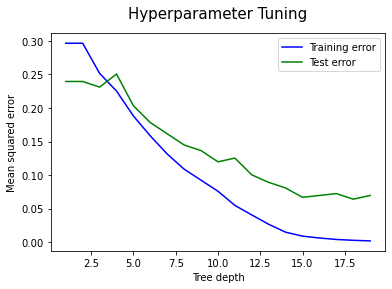

In [543]:
from sklearn.metrics import mean_squared_error as mse

bina_y = lb.transform(y_train_or)
bina_y_train = lb.transform(y_train)

max_depths = range(1, 20)
training_error = []
for max_depth in max_depths:
    model_1 = DecisionTreeClassifier(max_depth=max_depth, random_state=100)
    model_1.fit(X_train, bina_y_train)
    training_error.append(mse(bina_y_train, model_1.predict(X_train)))
    
testing_error = []
for max_depth in max_depths:
    model_2 = DecisionTreeClassifier(max_depth=max_depth, random_state=100)
    model_2.fit(X_train, bina_y_train)
    testing_error.append(mse(bina_y_val, model_2.predict(X_val)))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Test error')
plt.xlabel('Tree depth')
#plt.axvline(x=11, color='orange', linestyle='--')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()

# Random Forest Classifier

In [544]:
from sklearn.ensemble import RandomForestClassifier

In [545]:
from sklearn.ensemble import RandomForestClassifier
param_list = {'max_depth': [None] + list(np.arange(2, 50)),
              'min_samples_split': [10, 15, 20, 30, 50, 100, 150],
              'min_samples_leaf': [5, 10, 15, 20, 30, 50, 100, 150],
              'criterion': ['gini', 'entropy'],}

clf_rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, class_weight=None)

random_search = RandomizedSearchCV(clf_rf, param_distributions=param_list, n_iter=100, cv=4)
random_search.fit(X_train, y_train)
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.891 (std: 0.013)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 23, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.862 (std: 0.017)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 48, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.861 (std: 0.018)
Parameters: {'min_samples_split': 30, 'min_samples_leaf': 5, 'max_depth': 22, 'criterion': 'entropy'}



In [546]:
random_search.best_estimator_

RandomForestClassifier(max_depth=23, min_samples_leaf=5, min_samples_split=10)

In [547]:

clf_rf= RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=49,
                               min_samples_split=15, min_samples_leaf=5, class_weight=None)
clf_rf.fit(X_train,y_train)
y_pred_val_rf = clf_rf.predict(X_val)
y_pred_rf = clf_rf.predict(X_train)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_rf))
print('Train F1-score %s' % f1_score(y_train, y_pred_rf, average=None))
print(classification_report(y_train, y_pred_rf))


print('Test Accuracy %s' % accuracy_score(y_val, y_pred_val_rf))
print('Test F1-score %s' % f1_score(y_val, y_pred_val_rf, average=None))
print(classification_report(y_val, y_pred_val_rf))
confusion_matrix(y_val, y_pred_val_rf)

Train Accuracy 0.9699411217849395
Train F1-score [0.96939098 0.97047184]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1613
           1       0.95      0.99      0.97      1614

    accuracy                           0.97      3227
   macro avg       0.97      0.97      0.97      3227
weighted avg       0.97      0.97      0.97      3227

Test Accuracy 0.9108635097493036
Test F1-score [0.90588235 0.91534392]
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       180
           1       0.87      0.97      0.92       179

    accuracy                           0.91       359
   macro avg       0.92      0.91      0.91       359
weighted avg       0.92      0.91      0.91       359



array([[154,  26],
       [  6, 173]], dtype=int64)

Confusion matrix, without normalization
[[1594   20]
 [  77 1536]]
Normalized confusion matrix ('all')
[[0.49395724 0.00619771]
 [0.02386117 0.47598389]]
Normalized confusion matrix ('true')
[[0.98760843 0.01239157]
 [0.04773714 0.95226286]]


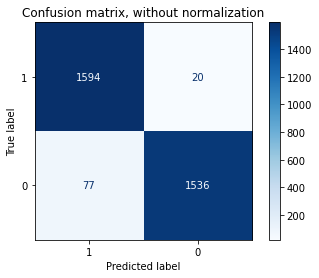

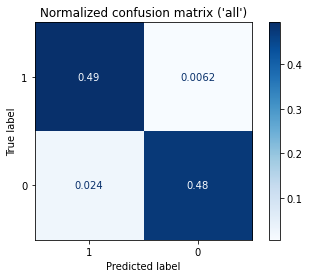

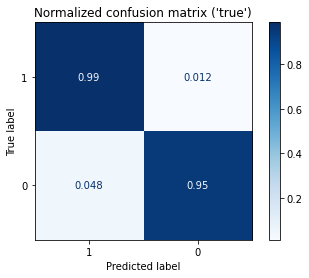

In [548]:
#CONFUSION MATRIX TRAIN
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix ('all')", 'all'),
                  ("Normalized confusion matrix ('true')", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf, X_train, y_train,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,labels=[1,0])
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [549]:
y_score_rf = clf_rf.predict_proba(X_val)
b_y_val = lb.transform(y_val)
b_y_pred = lb.transform(y_pred_val_rf)
fpr, tpr, _ = roc_curve(b_y_val, b_y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(b_y_val, b_y_pred, average=None)
roc_auc

0.911018001241465


0.911018001241465

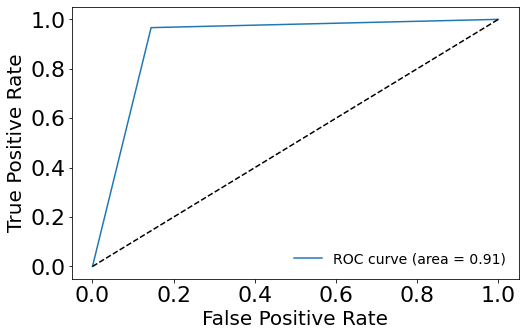

In [550]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [551]:
scores_accuracy_rf = cross_val_score(clf_rf, X_train, y_train, cv=4)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores_accuracy_rf.mean(), scores_accuracy_rf.std() * 2))

scores_f1_rf = cross_val_score(clf_rf, X_train, y_train, cv=4, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores_f1_rf.mean(), scores_f1_rf.std() * 2))

Accuracy: 0.8819 (+/- 0.03)
F1-score: 0.8861 (+/- 0.04)


# KNeighborsClassifier (KNN)

In [552]:
#clf = KNeighborsClassifier(n_neighbors=5)
#clf.fit(X, y)

# hold-out, cv, etc...

The optimal number of neighbors is  1 


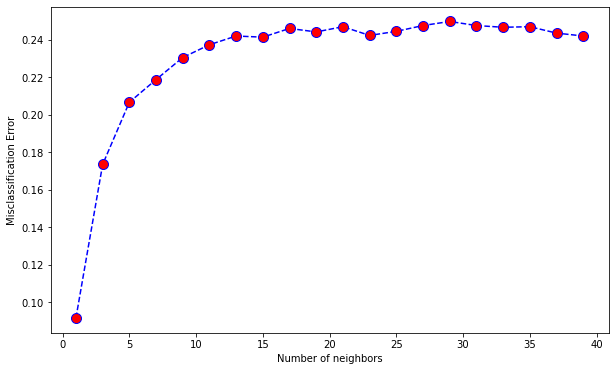

In [553]:
neighbors = []
cv_scores = []  
# perform 10 fold cross validation
for k in range(1, 40, 2):  
    neighbors.append(k)  
    knn = KNeighborsClassifier(n_neighbors = k)  
    scores_kn = cross_val_score(knn, X_train, y_train, cv = 4, scoring = 'accuracy')  
    cv_scores.append(scores_kn.mean()) 
error_rate = [1-x for x in cv_scores]  
    
# determining the best k  
optimal_k = neighbors[error_rate.index(min(error_rate))]  
print('The optimal number of neighbors is % d ' % optimal_k)  
    
# plot misclassification error versus k  
plt.figure(figsize = (10, 6))  
plt.plot(range(1, 40, 2), error_rate, color ='blue', linestyle ='dashed', marker ='o', 
         markerfacecolor ='red', markersize = 10) 
plt.xlabel('Number of neighbors')  
plt.ylabel('Misclassification Error')  
plt.show() 

In [554]:
clf_kn = KNeighborsClassifier(n_neighbors=5, weights= 'uniform') 
clf_kn.fit(X_train,y_train)

y_pred_val_knn = clf_kn.predict(X_val)
y_pred_knn = clf_kn.predict(X_train)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_knn))
print('Train F1-score %s' % f1_score(y_train, y_pred_knn, average=None))
print()
print(classification_report(y_train, y_pred_knn))
print('Test Accuracy %s' % accuracy_score(y_val, y_pred_val_knn))
print('Test F1-score %s' % f1_score(y_val, y_pred_val_knn, average=None))
print(classification_report(y_val, y_pred_val_knn))


scores_accuracy_kn = cross_val_score(clf_kn, X_train_or, y_train_or, cv=4)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores_accuracy_kn.mean(), scores_accuracy_kn.std() * 2))

scores_f1_kn = cross_val_score(clf_kn, X_train_or, y_train_or, cv=4, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores_f1_kn.mean(), scores_f1_kn.std() * 2))

Train Accuracy 0.8729470096064457
Train F1-score [0.85763889 0.8852826 ]

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1613
           1       0.81      0.98      0.89      1614

    accuracy                           0.87      3227
   macro avg       0.89      0.87      0.87      3227
weighted avg       0.89      0.87      0.87      3227

Test Accuracy 0.8328690807799443
Test F1-score [0.8089172  0.85148515]
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       180
           1       0.76      0.96      0.85       179

    accuracy                           0.83       359
   macro avg       0.86      0.83      0.83       359
weighted avg       0.86      0.83      0.83       359

Accuracy: 0.8990 (+/- 0.01)
F1-score: 0.5411 (+/- 0.02)


Confusion matrix, without normalization
[[1582   32]
 [ 378 1235]]
Normalized confusion matrix ('all')
[[0.49023861 0.00991633]
 [0.11713666 0.3827084 ]]
Normalized confusion matrix ('true')
[[0.98017348 0.01982652]
 [0.23434594 0.76565406]]


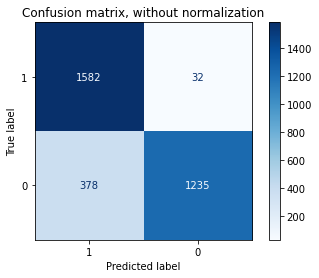

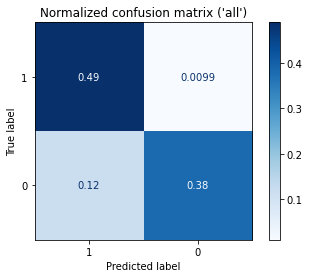

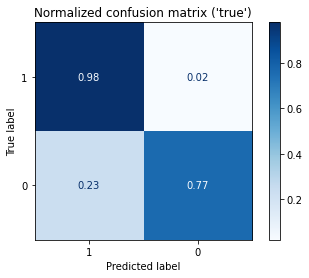

In [555]:
#CONFUSION MATRIX TRAIN
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix ('all')", 'all'),
                  ("Normalized confusion matrix ('true')", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_kn, X_train, y_train,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,labels=[1,0])
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix, without normalization
[[172   7]
 [ 53 127]]
Normalized confusion matrix ('all')
[[0.47910864 0.01949861]
 [0.14763231 0.35376045]]
Normalized confusion matrix ('true')
[[0.96089385 0.03910615]
 [0.29444444 0.70555556]]


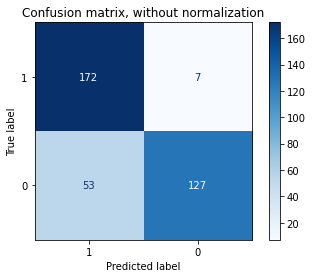

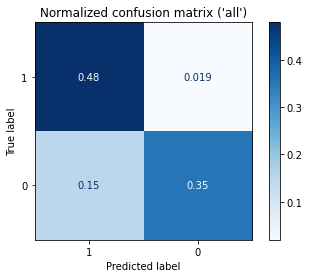

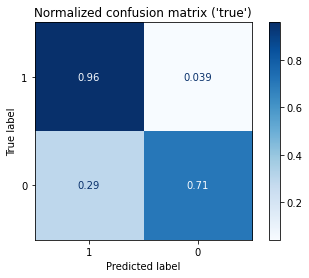

In [556]:
#CONFUSION MATRIX VALIDATION SET
titles_options =[("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix ('all')", 'all'),
                  ("Normalized confusion matrix ('true')", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_kn, X_val, y_val,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,labels=[1,0])
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Testing Decision Tree on Test set

In [557]:
y_pred_or_fn = clf_rf.predict(X_train_or)

In [558]:
y_pred_test_fn = clf_rf.predict(X_test)

In [559]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_test_fn))
print('F1-score %s' % f1_score(y_test, y_pred_test_fn, average=None))
print(classification_report(y_test, y_pred_test_fn))
confusion_matrix(y_test, y_pred_test_fn)

Accuracy 0.8302752293577982
F1-score [0.90053763 0.421875  ]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       399
           1       0.30      0.73      0.42        37

    accuracy                           0.83       436
   macro avg       0.63      0.78      0.66       436
weighted avg       0.91      0.83      0.86       436



array([[335,  64],
       [ 10,  27]], dtype=int64)

Confusion matrix, without normalization
[[ 27  10]
 [ 64 335]]
Normalized confusion matrix ('all')
[[0.06192661 0.02293578]
 [0.14678899 0.76834862]]
Normalized confusion matrix ('true')
[[0.72972973 0.27027027]
 [0.160401   0.839599  ]]


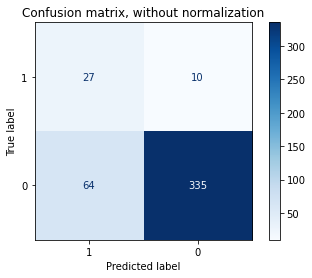

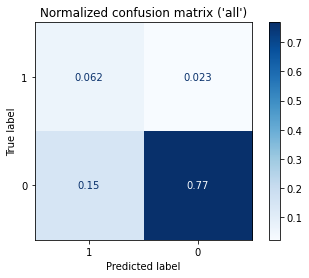

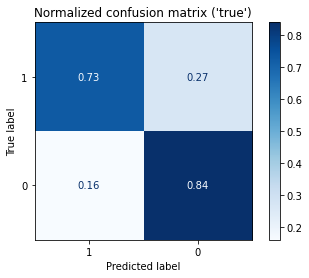

In [560]:
titles_options =[("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix ('all')", 'all'),
                  ("Normalized confusion matrix ('true')", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_rf, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,labels=[1,0])
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()